In [45]:
import numpy as np
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import re
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

In [5]:
file_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/troll/radar/'

file_list = sorted(glob.glob('/gws/nopw/j04/tone_ico_gws/cloudnet/troll/radar/2025*.nc'))  # Adjust path based on month


In [6]:
radar_accum = np.zeros([92])
daily_accum = {}

i = 0
for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 18
    b = 1.1

    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]
    
    # Convert time to seconds
    time_sec = time_var * 3600  # NumPy array

    # Remove NaNs
    valid_mask = ~np.isnan(precip)
    precip_clean = precip[valid_mask]
    time_sec_clean = time_sec[valid_mask]

    accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm
    daily_accum[base_time.date()] = accumulation

    radar_accum[i] = accumulation
    i = i + 1


daily_series = pd.Series(daily_accum)
daily_series.index = pd.to_datetime(daily_series.index)
daily_series.name = 'snowfall_accumulation_mm'
daily_series.index.name = 'date'
#daily_series.to_csv('troll_radar_march_accum.csv')


/tmp/ipykernel_112544/1439118744.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm


In [7]:
#file_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/radar/20230426_neumayer_mira.nc'
modfile_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/troll/era5/8c77d7d4c6e1d8b637bca6cfa6a85450.nc'
model = nc.Dataset(modfile_path)

# Coords of Neumayer III
minMod = np.array(model.variables['mntpr'][:, 48, 730]) * 60 * 60
maxMod = np.array(model.variables['mxtpr'][:, 48, 730]) * 60 * 60

In [8]:
print(model.variables['latitude'][48])
print(model.variables['longitude'][730])

-72.0
2.5


In [9]:
print(model.variables['valid_time'][2208])
#1748736000

1748736000


In [10]:
eraUpperAccum = np.trapz(maxMod[:2208])
eraLowerAccum = np.trapz(minMod[:2208])

print(eraUpperAccum)
print(eraLowerAccum)

52.086353
45.36023


/tmp/ipykernel_112544/1706324909.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  eraUpperAccum = np.trapz(maxMod[:2208])
/tmp/ipykernel_112544/1706324909.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  eraLowerAccum = np.trapz(minMod[:2208])


In [11]:
accum_daily_low = np.sum(minMod[:2208].reshape(92, 24), axis=1)
accum_daily_high = np.sum(maxMod[:2208].reshape(92, 24), axis=1)


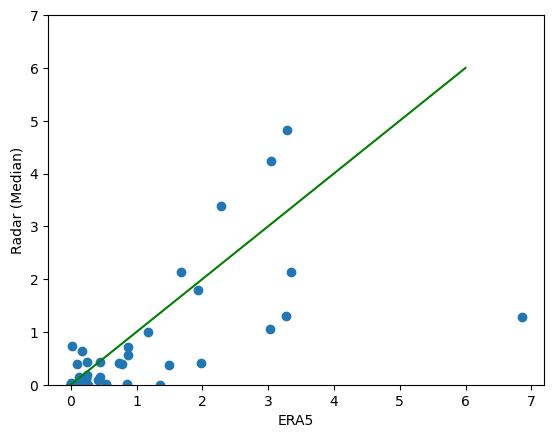

In [12]:
plt.scatter(accum_daily_low, radar_accum)
plt.xlabel("ERA5")
plt.ylabel("Radar (Median)")
plt.ylim(0, 7)
plt.plot(np.arange(0, 7), np.arange(0, 7), c='g')

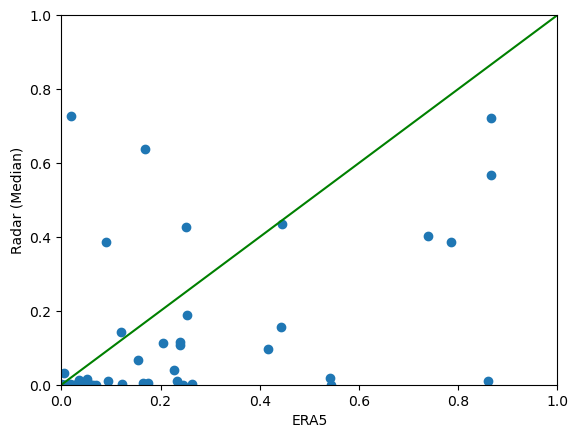

In [13]:
plt.scatter(accum_daily_low, radar_accum)
plt.xlabel("ERA5")
plt.ylabel("Radar (Median)")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(np.arange(0, 7), np.arange(0, 7), c='g')

In [14]:
radar_accum_upper = np.zeros([92])

i = 0
for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 43
    b = 1.1

    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]
    
    # Convert time to seconds
    time_sec = time_var * 3600  # NumPy array

    # Remove NaNs
    valid_mask = ~np.isnan(precip)
    precip_clean = precip[valid_mask]
    time_sec_clean = time_sec[valid_mask]

    accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm

    radar_accum_upper[i] = accumulation
    i = i + 1





/tmp/ipykernel_112544/2152701335.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm


In [15]:
radar_accum_lower = np.zeros([92])

i = 0
for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 11
    b = 1.1

    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]
    
    # Convert time to seconds
    time_sec = time_var * 3600  # NumPy array

    # Remove NaNs
    valid_mask = ~np.isnan(precip)
    precip_clean = precip[valid_mask]
    time_sec_clean = time_sec[valid_mask]

    accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm

    radar_accum_lower[i] = accumulation
    i = i + 1





/tmp/ipykernel_112544/3239681642.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm


In [16]:
print(np.sum(radar_accum_lower))
print(np.sum(radar_accum_upper))


46.58063266632536
13.488220789457554


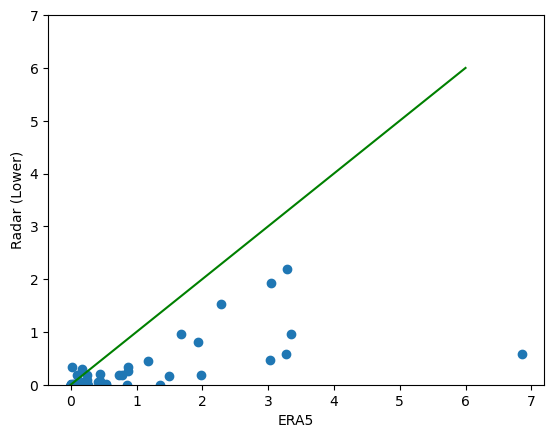

In [17]:
plt.scatter(accum_daily_low, radar_accum_upper)
plt.xlabel("ERA5")
plt.ylabel("Radar (Lower)")
plt.ylim(0, 7)
plt.plot(np.arange(0, 7), np.arange(0, 7), c='g')

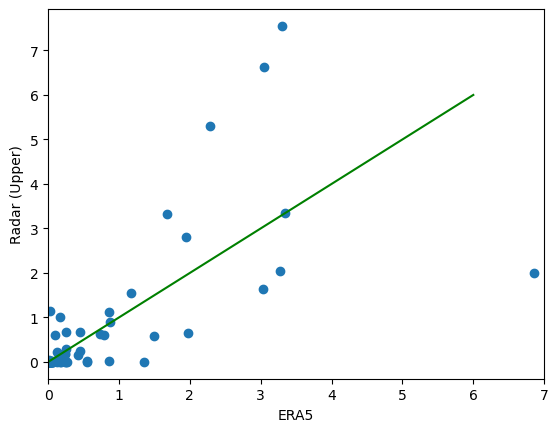

In [18]:
plt.scatter(accum_daily_low, radar_accum_lower)
plt.xlabel("ERA5")
plt.ylabel("Radar (Upper)")
plt.xlim(0, 7)
plt.plot(np.arange(0, 7), np.arange(0, 7), c='g')

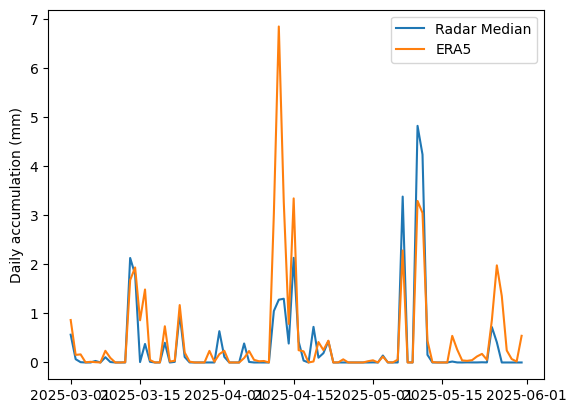

In [19]:
dates = np.arange('2025-03-01', '2025-06-01', dtype='datetime64[D]')

plt.plot(dates, radar_accum, label='Radar Median')
plt.plot(dates, accum_daily_low, label='ERA5')
plt.ylabel('Daily accumulation (mm)')
#plt.plot(dates, accum_daily_high, label='ERA5 high')
plt.legend()

In [20]:
print(np.corrcoef(radar_accum, accum_daily_low))

[[1.         0.70871728]
 [0.70871728 1.        ]]


In [21]:
# Put uncertainties on the time series plot
# Make a plot for the 12th-14th with hourly accum from ERA5 and radar
# download ERA5 median and plot it

#statistics: bias, rmse, correlation, coefficient of efficiency, for model-radar comparison
# also rmsd (vs rmse)
# when moving to 2D - correlation etc as a function of distance from the radar 

# plot these metrics separated into the absolute accumulation values (eg 0-1 mm, 1-5 mm)

# violin plot of the daily accumulation distribution across march-may for both era and radar



In [22]:
print(radar_accum[12])
print(accum_daily_low[12])
print(accum_daily_high[12])
print(dates[12])

print("14th:")
print(radar_accum[13])
print(accum_daily_low[13])
print(accum_daily_high[13])
print(dates[13])

print("12th:")
print(radar_accum[11])
print(accum_daily_low[11])
print(accum_daily_high[11])
print(dates[11])

2.131634788580062
1.6801357
1.8509388
2025-03-13
14th:
1.7963170886712907
1.9384861
2.1251678
2025-03-14
12th:
8.478655196302754e-06
0.0051498413
0.018024445
2025-03-12


In [23]:
print("Radar accumulation = " + str(np.sum(radar_accum)) + " mm")
print("Radar lower accumulation = " + str(np.sum(radar_accum_upper)) + " mm")
print("Radar upper accumulation = " + str(np.sum(radar_accum_lower)) + " mm")
print("ERA5 lower accumulation = " + str(np.sum(accum_daily_low)) + " mm")
print("ERA5 upper accumulation = " + str(np.sum(accum_daily_high)) + " mm")

Radar accumulation = 29.769337953062596 mm
Radar lower accumulation = 13.488220789457554 mm
Radar upper accumulation = 46.58063266632536 mm
ERA5 lower accumulation = 45.501 mm
ERA5 upper accumulation = 52.244278 mm


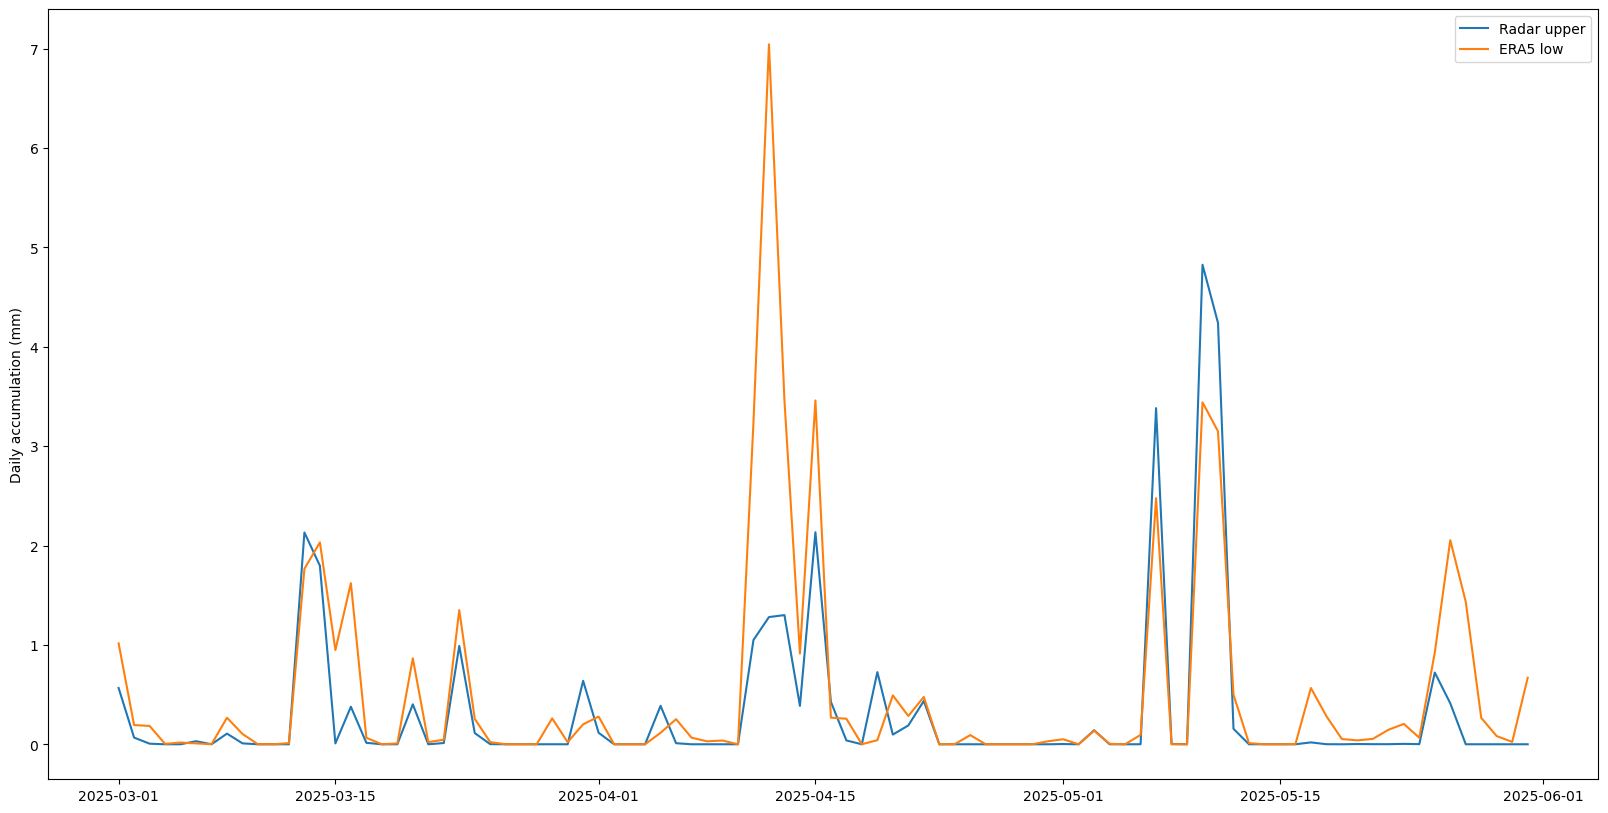

In [24]:
dates = np.arange('2025-03-01', '2025-06-01', dtype='datetime64[D]')
accum_daily_mean = (accum_daily_low+accum_daily_high)/2

plt.figure(figsize=(20, 10))
plt.plot(dates, radar_accum, label='Radar upper')
plt.plot(dates, accum_daily_mean, label='ERA5 low')
#plt.fill_between(dates, accum_daily_low, accum_daily_high)
#plt.fill_between(dates, radar_accum_upper, radar_accum_lower)
plt.ylabel("Daily accumulation (mm)")
#plt.plot(dates, accum_daily_high, label='ERA5 high')
plt.legend()

In [25]:
hour_accum = np.zeros([48])
#daily_accum = {}

start_time = datetime(2025, 3, 13)
end_time = datetime(2025, 3, 15)  # exclusive


j = 0
for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 18
    b = 1.1

    precip = (z / a) ** (1 / b)

    

    # Extract time (hours since midnight)
    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_date = datetime.strptime(date_str, '%Y%m%d')
    time_var = dset.variables['time'][:]  # shape: (n,)
    dateStamps = np.array([base_date + timedelta(hours=float(t)) for t in time_var])

    # Convert to arrays and filter time range
    timestamps = np.array(time_var)


    valid_mask = (
        ~np.isnan(precip) &
        (dateStamps >= start_time) &
        (dateStamps < end_time)
    )
    timestamps = timestamps[valid_mask]
    precip_clean = precip[valid_mask]


    if (base_date >= start_time) & (base_date < end_time):
        for i in range(24):
            hourY = precip_clean[np.where(np.logical_and(timestamps > i, timestamps < (i + 1)))]
            hourX = timestamps[np.where(np.logical_and(timestamps > i, timestamps < (i + 1)))]
            #print(hourX)
            
            accumulation = np.trapz(hourY, hourX)   # result in mm
            hour_accum[j*24+i] = accumulation


        j = j + 1




/tmp/ipykernel_112544/3244327862.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(hourY, hourX)   # result in mm


In [26]:
def compute_hourly_accumulation(timestamps, precip, hour_start):
    time_sec = np.array([(ts - hour_start).total_seconds() for ts in timestamps])
    precip = np.array(precip)

    valid_mask = ~np.isnan(precip)
    time_sec = time_sec[valid_mask]
    precip = precip[valid_mask]

    if len(precip) < 2:
        return np.nan  # Not enough data to interpolate

    full_hour_sec = np.linspace(0, 3600, 60)  # one-minute resolution
    interpolated_precip = np.interp(full_hour_sec, time_sec, precip)

    accumulation = np.trapz(interpolated_precip, full_hour_sec) / 3600  # in mm
    return accumulation

In [27]:
start_time = datetime(2025, 3, 13, 0, 0, 0)
end_time = datetime(2025, 3, 15, 0, 0, 0)

# Initialize array for 48 hours
hourly_accum_array = np.full(48, np.nan)
# Create index mapping: {timestamp -> array index}
target_hours = [start_time + timedelta(hours=i) for i in range(48)]
hour_index_map = {ts: i for i, ts in enumerate(target_hours)}

for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 18
    b = 1.1
    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]  # in hours
    timestamps = [base_time + timedelta(hours=float(t)) for t in time_var]

    df = pd.DataFrame({'precip': precip}, index=pd.to_datetime(timestamps))
    df = df.sort_index()
    df['hour'] = df.index.floor('H')

    for hour, group in df.groupby('hour'):
        if start_time <= hour < end_time:
            ts = group.index.to_numpy()
            pr = group['precip'].to_numpy()
            accum = compute_hourly_accumulation(ts, pr, hour)
            idx = hour_index_map[hour]
            hourly_accum_array[idx] = accum


/tmp/ipykernel_112544/3323504411.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df.index.floor('H')
/tmp/ipykernel_112544/3323504411.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df.index.floor('H')
/tmp/ipykernel_112544/3323504411.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df.index.floor('H')
/tmp/ipykernel_112544/3323504411.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df.index.floor('H')
/tmp/ipykernel_112544/3323504411.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df.index.floor('H')
/tmp/ipykernel_112544/3323504411.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instea

In [29]:
print(model.variables['valid_time'][264])
print(model.variables['valid_time'][336])

marchMinMod = minMod[288:336]
marchMaxMod = maxMod[288:336]

1741737600
1741996800


In [30]:
print("March 13th: ")
print("Radar Accumulation = " + str(np.sum(hourly_accum_array[:24])))
print("ERA5 Accumulation = " + str(np.sum(marchMinMod[:24])))
print("March 14th: ")
print("Radar Accumulation = " + str(np.sum(hourly_accum_array[24:])))
print("ERA5 Accumulation = " + str(np.sum(marchMinMod[24:])))

March 13th: 
Radar Accumulation = 2.295304792761819
ERA5 Accumulation = 1.6801357
March 14th: 
Radar Accumulation = 1.9649120796407156
ERA5 Accumulation = 1.9384861


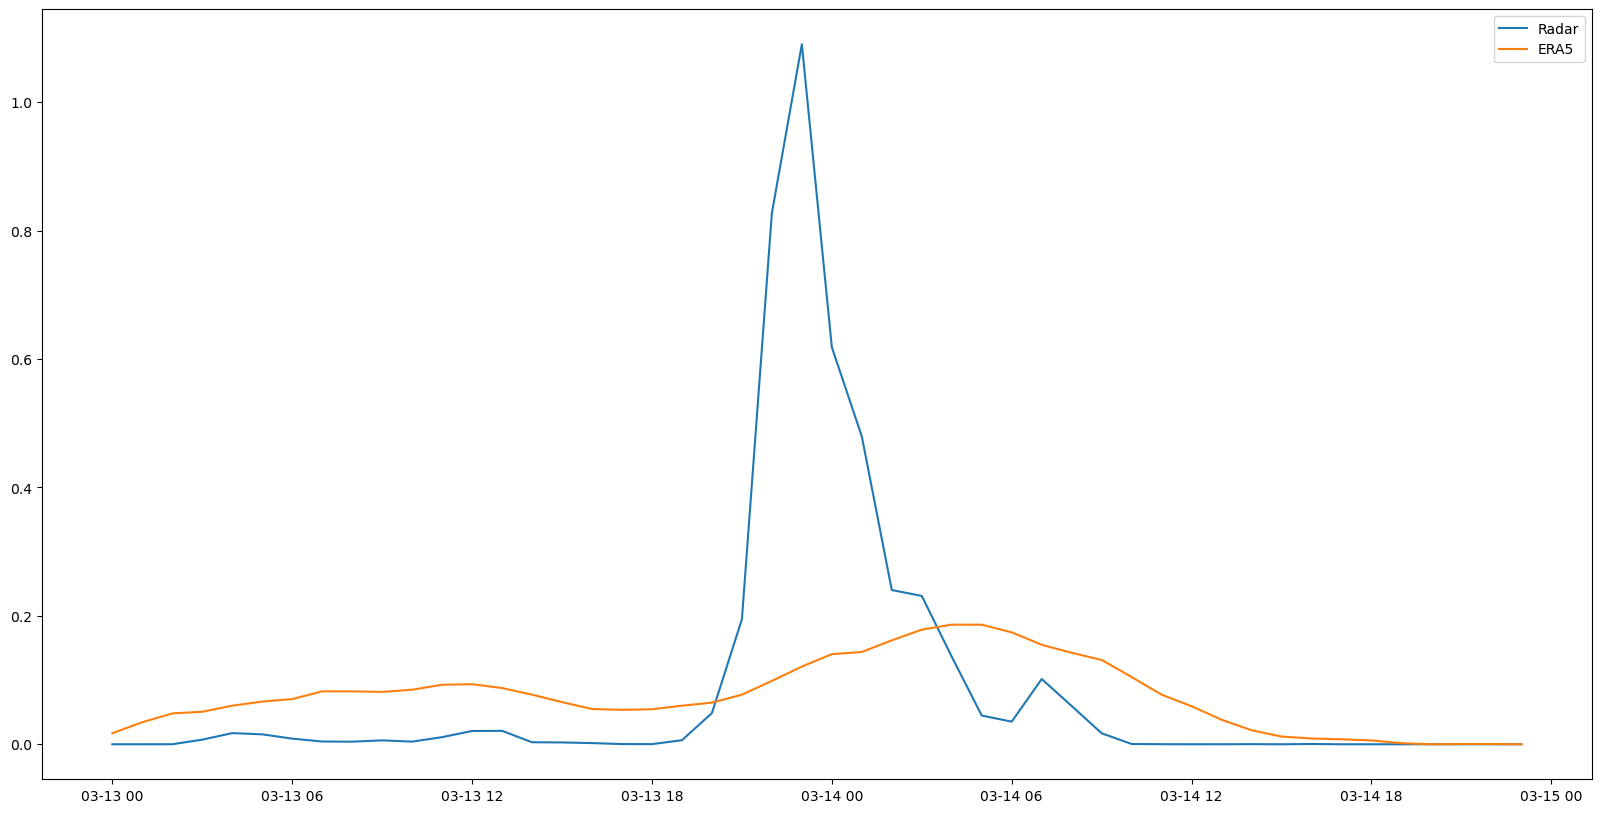

In [48]:
x_time = np.array([start_time + timedelta(hours=i) for i in range(48)])
plt.figure(figsize=(20, 10))
plt.plot(x_time, hourly_accum_array, label='Radar')
plt.plot(x_time, marchMinMod, label='ERA5')
plt.legend()

(0.0, 1.0)

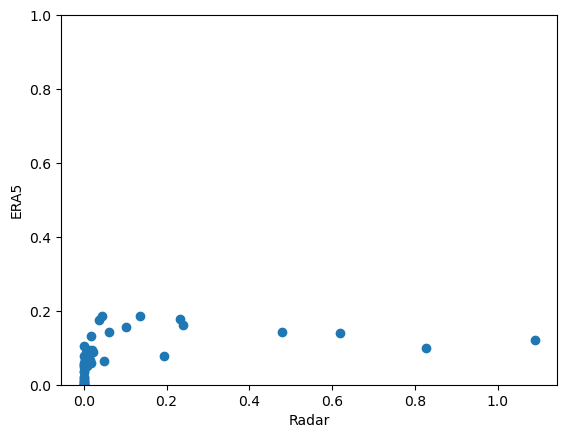

In [32]:
plt.scatter(hourly_accum_array, marchMinMod)
plt.xlabel('Radar')
plt.ylabel('ERA5')
plt.ylim(0, 1)

(0.0, 0.2)

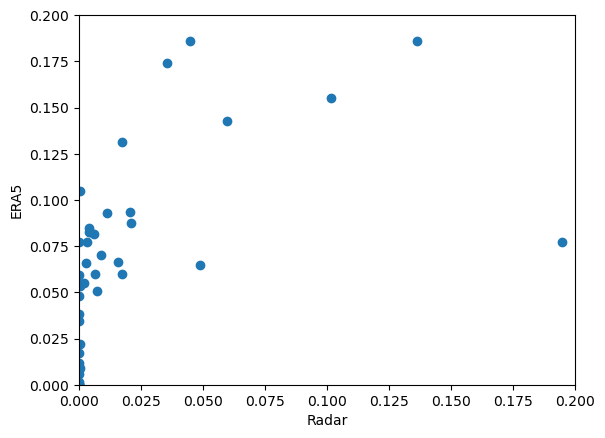

In [33]:
plt.scatter(hourly_accum_array, marchMinMod)
plt.xlabel('Radar')
plt.ylabel('ERA5')
plt.ylim(0, 0.2)
plt.xlim(0, 0.2)

In [34]:
import seaborn as sns

{'bodies': [<matplotlib.collections.FillBetweenPolyCollection at 0x7f298d07a490>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f298d07a5d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f298d07a710>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f298d07a850>}

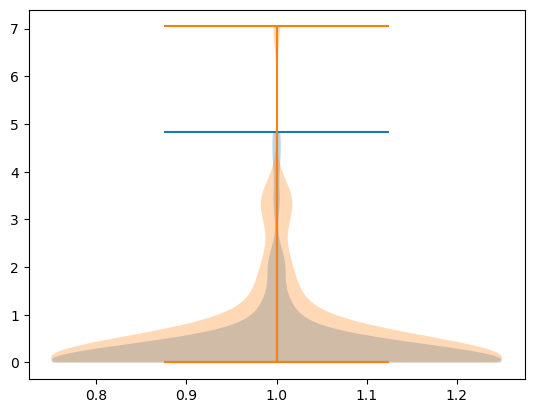

In [35]:
plt.violinplot(radar_accum)
plt.violinplot(accum_daily_mean)

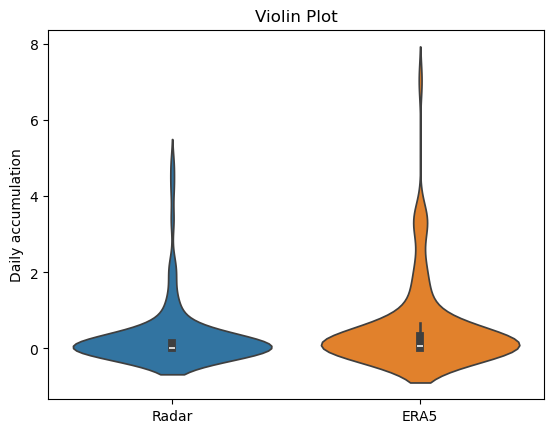

In [39]:
data = [radar_accum, accum_daily_mean]

sns.violinplot(data=data)
plt.xticks([0, 1], ['Radar', 'ERA5'])
plt.title("Violin Plot")
plt.ylabel("Daily accumulation")
plt.show()

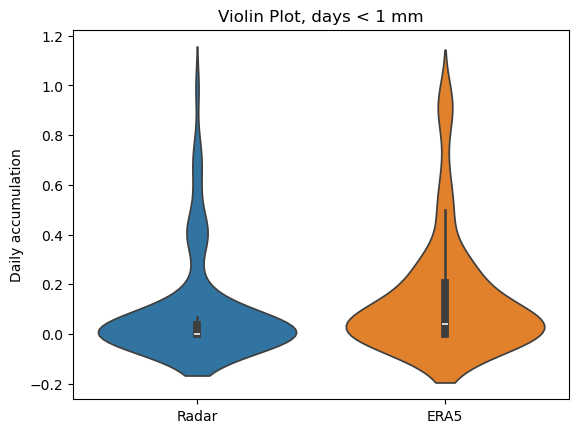

In [43]:
data = [radar_accum[np.where(radar_accum < 1)], accum_daily_mean[np.where(accum_daily_mean < 1)]]

sns.violinplot(data=data)
plt.xticks([0, 1], ['Radar', 'ERA5'])
plt.title("Violin Plot, days < 1 mm")
plt.ylabel("Daily accumulation")
plt.show()

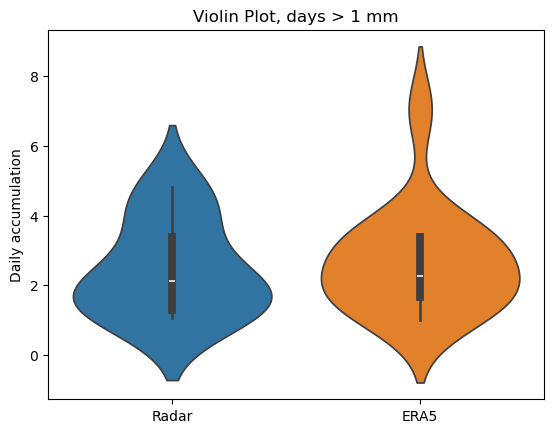

In [44]:
data = [radar_accum[np.where(radar_accum > 1)], accum_daily_mean[np.where(accum_daily_mean > 1)]]

sns.violinplot(data=data)
plt.xticks([0, 1], ['Radar', 'ERA5'])
plt.title("Violin Plot, days > 1 mm")
plt.ylabel("Daily accumulation")
plt.show()

In [47]:
newMask = ~np.isnan(radar_accum) & ~np.isnan(accum_daily_mean)

# Step 2: Apply mask to get valid pairs
a_valid = radar_accum[newMask]
b_valid = accum_daily_mean[newMask]

# Step 3: Compute metrics
mae = mean_absolute_error(a_valid, b_valid)
mse = mean_squared_error(a_valid, b_valid)
rmse = np.sqrt(mse)
bias = np.mean(a_valid - b_valid)
corr = np.corrcoef(a_valid, b_valid)[0, 1]
r2 = r2_score(a_valid, b_valid)

# Step 4: Print results
print("Comparison Metrics:")
print(f"  MAE : {mae:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  Bias: {bias:.3f}")
print(f"  Corr: {corr:.3f}")
print(f"  R²  : {r2:.3f}")

Comparison Metrics:
  MAE : 0.324
  RMSE: 0.801
  Bias: -0.208
  Corr: 0.711
  R²  : 0.076


In [51]:
start_time = datetime(2025, 3, 1, 0, 0, 0)
end_time = datetime(2025, 6, 1, 0, 0, 0)

# Initialize array for 48 hours
radar_fullhour_array = np.full(2208, np.nan)
# Create index mapping: {timestamp -> array index}
target_hours = [start_time + timedelta(hours=i) for i in range(2208)]
hour_index_map = {ts: i for i, ts in enumerate(target_hours)}

for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 18
    b = 1.1
    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]  # in hours
    timestamps = [base_time + timedelta(hours=float(t)) for t in time_var]

    df = pd.DataFrame({'precip': precip}, index=pd.to_datetime(timestamps))
    df = df.sort_index()
    df['hour'] = df.index.floor('H')

    for hour, group in df.groupby('hour'):
        if start_time <= hour < end_time:
            ts = group.index.to_numpy()
            pr = group['precip'].to_numpy()
            accum = compute_hourly_accumulation(ts, pr, hour)
            idx = hour_index_map[hour]
            radar_fullhour_array[idx] = accum


/tmp/ipykernel_112544/312092004.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df.index.floor('H')
/tmp/ipykernel_112544/2081857436.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(interpolated_precip, full_hour_sec) / 3600  # in mm
/tmp/ipykernel_112544/312092004.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df.index.floor('H')
/tmp/ipykernel_112544/2081857436.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(interpolated_precip, full_hour_sec) / 3600  # in mm
/tmp/ipykernel_112544/312092004.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'

Text(0.5, 1.0, 'Radar vs ERA5, by hour')

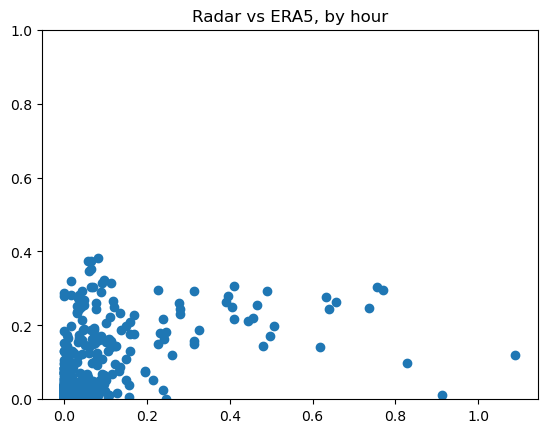

In [61]:
plt.scatter(radar_fullhour_array, minMod[:2208])
plt.ylim(0, 1)
plt.title("Radar vs ERA5, by hour")

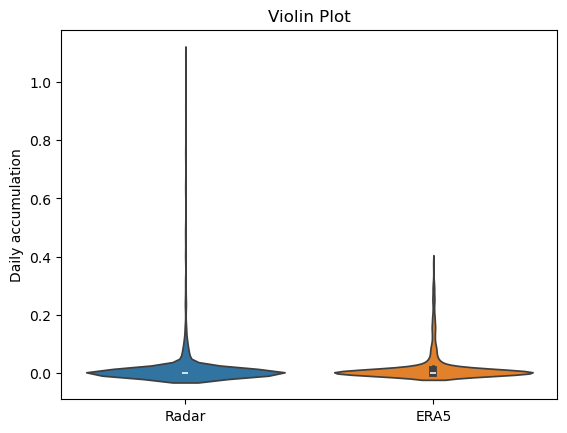

In [66]:
c = minMod[:2208]
data = [radar_fullhour_array, c]

sns.violinplot(data=data)
plt.xticks([0, 1], ['Radar', 'ERA5'])
plt.title("Violin Plot")
plt.ylabel("Daily accumulation")
plt.show()

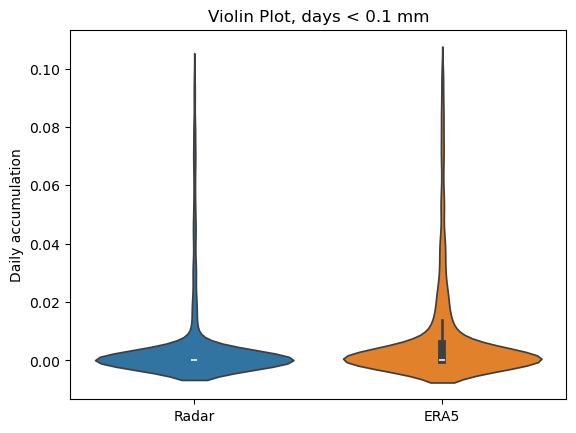

In [67]:
data = [radar_fullhour_array[np.where(radar_fullhour_array < 0.1)], c[np.where(c < 0.1)]]

sns.violinplot(data=data)
plt.xticks([0, 1], ['Radar', 'ERA5'])
plt.title("Violin Plot, days < 0.1 mm")
plt.ylabel("Daily accumulation")
plt.show()